# Published Items for the Center for Health AI

This takes a list of authors and searches for any items published this year, grabs the proper citation from manubot-cite, and creates a markdown and MS Word document.

This isn't a replacement for a proper data pipeline. Just a demo to see if the selection logic is sound.

2021/12/20 stephen.taylor@cuanschutz.edu First demo

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import json
import logging
import manubot
import requests
import pandas as pd
import pandoc
import datetime
import subprocess

from manubot.cite.citations import Citations

from datetime import date
from ratelimit import limits, RateLimitException, sleep_and_retry

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

BUILD_FOLDER = "_build"

<IPython.core.display.Javascript object>

In [3]:
# These can be used as arguments via papermill

# Looking at this year's items
THIS_YEAR = 2021

# If you have an NCBI API key, enter it here
API_KEY = ""

# For testing, set a sample size between 0 and 1.0
SAMPLE_FRACTION = 1.0

<IPython.core.display.Javascript object>

In [4]:
# We get faster NCBI rates if we use a key.
if API_KEY:
    NCBI_RATE_LIMIT = 10
else:
    NCBI_RATE_LIMIT = 3

NCBI_RATE_LIMIT

3

<IPython.core.display.Javascript object>

In [5]:
# will write out to a folder
if not os.path.exists(BUILD_FOLDER):
    os.makedirs(BUILD_FOLDER)

<IPython.core.display.Javascript object>

In [6]:
# Read in the authors and their specific search terms
authors_df = pd.read_json("authors.json", orient="index")
authors_df

,author_type,search_term
Aquilante C,contributor,(Aquilante C[Author])
Barnes K,contributor,(Barnes K[Author])
Boorgula M,contributor,(Boorgula M[Author])
Brooks I,contributor,(Brooks I[Author])
Campbell M,contributor,(Campbell M[Author])
Casey Greene,pi,(Casey Greene)
Claw K,contributor,(Claw K[Author])
Cohen M,contributor,(Cohen M[Author])
Coors M,contributor,(Coors M[Author])
Crooks K,contributor,(Crooks K[Author])


<IPython.core.display.Javascript object>

In [7]:
# for testing it's nice to take a sample
if 0 < SAMPLE_FRACTION < 1.0:
    authors_df = authors_df.sample(frac=SAMPLE_FRACTION)

<IPython.core.display.Javascript object>

In [8]:
# convert into a dict
author_records = authors_df.to_dict("index")
author_records

{'Reisdorph N': {'author_type': 'contributor',
  'search_term': '(Reisdorph N[Author])'},
 'Rosenberg M': {'author_type': 'contributor',
  'search_term': '(Rosenberg M[Author])'},
 'Crooks K': {'author_type': 'contributor',
  'search_term': '(Crooks K[Author])'},
 'Santorico S': {'author_type': 'contributor',
  'search_term': '(Santorico S[Author])'},
 'Lowery J': {'author_type': 'contributor',
  'search_term': '(Lowery J[Author])'}}

<IPython.core.display.Javascript object>

In [9]:
# add a date to restrict to this year
for k, v in author_records.items():
    # Restrict contributors to CU items
    if v["author_type"] == "contributor":
        v[
            "search_term"
        ] = f"({v['search_term']} AND ((\"University of Colorado\") OR (\"Colorado Center for Personalized Medicine\")))"

    # filter by date
    v[
        "search_term"
    ] = f"""("{THIS_YEAR}/01/01"[PubDate] : "3000"[PubDate]) AND {v["search_term"]})"""
author_records

{'Reisdorph N': {'author_type': 'contributor',
  'search_term': '("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Reisdorph N[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))'},
 'Rosenberg M': {'author_type': 'contributor',
  'search_term': '("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Rosenberg M[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))'},
 'Crooks K': {'author_type': 'contributor',
  'search_term': '("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Crooks K[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))'},
 'Santorico S': {'author_type': 'contributor',
  'search_term': '("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Santorico S[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))'},
 'Lowery J': {'author_type': 'contributor',
  'search_term': '("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Lowery J[Aut

<IPython.core.display.Javascript object>

In [10]:
@sleep_and_retry
@limits(calls=NCBI_RATE_LIMIT, period=60)
def lookup_ncbi(term, year, api_key=None):
    # look up IDs a chunk at a time
    # NCBI asks that we use an API key... I've used mine in the past, but
    # pulled this out for source.
    ids = []

    d = date(year, 1, 1)
    delta = date.today() - d

    params = {
        "term": term,
        "format": "pmid",
        "db": "pmc",
        "tool": "CUAnschutz-Center_for_Health_AI-DEV",
        "email": "Stephen.Taylor@cuanschutz.edu",
        "format": "json",
        "retmax": 100,
        "retstart": 0,
        "reldate": delta.days,
    }

    if api_key:
        params["api_key"] = api_key

    # page through the results until there are no more ids
    while True:
        r = requests.get(
            "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi", params
        )
        if r.status_code == 200:
            result = r.json()["esearchresult"]
        else:
            logging.error(f"NCBI returned a status code of {r.status_code}.")
            break

        if len(result["idlist"]) == 0:
            # no more IDs
            break
        else:
            # append the IDs to the results...
            ids = ids + result["idlist"]
            # and move the start chunk up by the size of retmax
            params["retstart"] += params["retmax"]

    return ids

<IPython.core.display.Javascript object>

In [11]:
# I would like to do this in parallel, but the deal with NCBI is we agree not to do that
id_dict = {}
for author, v in author_records.items():
    logging.info(f"Looking up `{author}` using {v['search_term']}")
    ids = lookup_ncbi(term=v["search_term"], year=THIS_YEAR, api_key=API_KEY)

    for id in ids:
        # adding the PMC here to make it more usable against the manubot cites later
        pmc_id = f"PMC{id}"
        if not id_dict.get(pmc_id):
            # create an empty nested dict
            id_dict[pmc_id] = {"authors": []}
        id_dict[pmc_id]["authors"].append(author)

id_dict

INFO:root:Looking up `Reisdorph N` using ("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Reisdorph N[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))
INFO:root:Looking up `Rosenberg M` using ("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Rosenberg M[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))
INFO:root:Looking up `Crooks K` using ("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Crooks K[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))
INFO:root:Looking up `Santorico S` using ("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Santorico S[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))
INFO:root:Looking up `Lowery J` using ("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Lowery J[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))


{'PMC8528232': {'authors': ['Reisdorph N']},
 'PMC8269254': {'authors': ['Reisdorph N']},
 'PMC8070949': {'authors': ['Reisdorph N']},
 'PMC8076692': {'authors': ['Reisdorph N']},
 'PMC7999201': {'authors': ['Reisdorph N']},
 'PMC7996814': {'authors': ['Reisdorph N']},
 'PMC7797585': {'authors': ['Rosenberg M']},
 'PMC8095117': {'authors': ['Crooks K']},
 'PMC8170963': {'authors': ['Santorico S']},
 'PMC8130444': {'authors': ['Santorico S']}}

<IPython.core.display.Javascript object>

How many items found?

In [12]:
len(id_dict)

10

<IPython.core.display.Javascript object>

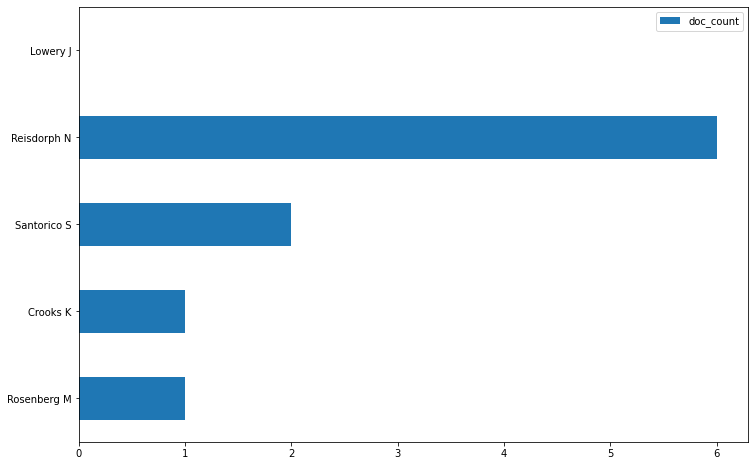

<IPython.core.display.Javascript object>

In [13]:
# useful to get a handle on the shape of the data
doc_count = {}
for k, v in id_dict.items():
    for author in v["authors"]:
        if not doc_count.get(author):
            doc_count[author] = 0
        doc_count[author] += 1

authors_df["doc_count"] = pd.Series(doc_count)
ax = authors_df.sort_values(by="doc_count").plot.barh(figsize=(12, 8))
fig = ax.get_figure()
fig.savefig(os.path.join(BUILD_FOLDER, "author_items.png"))

In [14]:
# Retrive the references from manubot
pmc_keys = [f"pmc:{key}" for key in id_dict]
citations = Citations(pmc_keys)
cites = citations.get_csl_items()
cites

[{'source': 'PubMed',
  'accessed': {'date-parts': [[2021, 12, 22]]},
  'id': 'GjCALWbY',
  'title': 'Feasibility of Frailty Assessment Integrated with Cardiac Implantable Electronic Device Clinic Follow-up: A Pilot Investigation',
  'author': [{'family': 'Albakri', 'given': 'Abdel'},
   {'family': 'Orkaby', 'given': 'Ariela'},
   {'family': 'Rosenberg', 'given': 'Michael A'}],
  'container-title-short': 'Gerontol Geriatr Med',
  'container-title': 'Gerontology & geriatric medicine',
  'publisher': 'SAGE Publications',
  'ISSN': '2333-7214',
  'issued': {'date-parts': [[2021, 1, 9]]},
  'page': '2333721420987342',
  'volume': '7',
  'PMID': '33457464',
  'PMCID': 'PMC7797585',
  'DOI': '10.1177/2333721420987342',
  'type': 'article-journal',
  'URL': 'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7797585/',
  'note': 'This CSL Item was generated by Manubot v0.5.1 from its persistent identifier (standard_id).\nstandard_id: pmc:PMC7797585'},
 {'source': 'PubMed',
  'accessed': {'date-part

<IPython.core.display.Javascript object>

In [15]:
# I'm going to want to sort these later.
for rec in cites:
    key = rec["PMCID"]

    id_dict[key]["csljson"] = rec
    id_dict[key]["title"] = rec["title"]

    # all this for the date!
    issued_date_parts = rec["issued"]["date-parts"][0]
    date_str = str(issued_date_parts[0])
    try:
        date_str += f"/{issued_date_parts[1]}"
        try:
            date_str += f"/{issued_date_parts[2]}"
        except:
            pass
    except:
        pass

    id_dict[key]["issued_date"] = date_str

id_dict

{'PMC8528232': {'authors': ['Reisdorph N'],
  'csljson': {'source': 'PubMed',
   'accessed': {'date-parts': [[2021, 12, 22]]},
   'id': '1HmE6fmAD',
   'title': 'Lipid nanoparticle formulation of niclosamide (nano NCM) effectively inhibits SARS-CoV-2 replication <i>in vitro</i>',
   'author': [{'family': 'Wang', 'given': 'Guankui'},
    {'family': 'Gaikwad', 'given': 'Hanmant'},
    {'family': 'McCarthy', 'given': 'Mary K'},
    {'family': 'Gonzalez-Juarrero', 'given': 'Mercedes'},
    {'family': 'Li', 'given': 'Yue'},
    {'family': 'Armstrong', 'given': 'Michael'},
    {'family': 'Reisdorph', 'given': 'Nichole'},
    {'family': 'Morrison', 'given': 'Thomas E'},
    {'family': 'Simberg', 'given': 'Dmitri'}],
   'container-title-short': 'Precis Nanomed',
   'container-title': 'Precision nanomedicine',
   'ISSN': '2639-9431',
   'issued': {'date-parts': [[2021, 4, 17]]},
   'page': '724-737',
   'volume': '4',
   'issue': '1',
   'PMID': '34676370',
   'PMCID': 'PMC8528232',
   'DOI': '

<IPython.core.display.Javascript object>

In [16]:
# sort the dictionary by title
df = pd.DataFrame.from_dict(id_dict, orient="index")
df.sort_values(by="title", inplace=True)
df

,authors,csljson,title,issued_date
PMC7996814,[Reisdorph N],"{'source': 'PubMed', 'accessed': {'date-parts'...",Collection and Storage of Human Plasma for Mea...,2021/2/26
PMC7797585,[Rosenberg M],"{'source': 'PubMed', 'accessed': {'date-parts'...",Feasibility of Frailty Assessment Integrated w...,2021/1/9
PMC8170963,[Santorico S],"{'source': 'PubMed', 'accessed': {'date-parts'...",Genome-wide association analysis of metabolic ...,2021/6/1
PMC8130444,[Santorico S],"{'source': 'PubMed', 'accessed': {'date-parts'...",Genome-wide copy number variations in a large ...,2021/5/17
PMC8528232,[Reisdorph N],"{'source': 'PubMed', 'accessed': {'date-parts'...",Lipid nanoparticle formulation of niclosamide ...,2021/4/17
PMC8070949,[Reisdorph N],"{'source': 'PubMed', 'accessed': {'date-parts'...",Lipidomics-Based Comparison of Molecular Compo...,2021/4/14
PMC7999201,[Reisdorph N],"{'source': 'PubMed', 'accessed': {'date-parts'...",Metabolomic Profiling Reveals Sex Specific Ass...,2021/3/11
PMC8076692,[Reisdorph N],"{'source': 'PubMed', 'accessed': {'date-parts'...",Specialized pro-resolving mediator lipidome an...,2021/4/1
PMC8269254,[Reisdorph N],"{'source': 'PubMed', 'accessed': {'date-parts'...",Systems Analysis of Gut Microbiome Influence o...,2021/5/18
PMC8095117,[Crooks K],"{'source': 'PubMed', 'accessed': {'date-parts'...",Zika Virus Congenital Syndrome and <i>MTOR</i>...,2021/4/22


<IPython.core.display.Javascript object>

In [17]:
keys = ",".join(df.index.to_list())
keys

'PMC7996814,PMC7797585,PMC8170963,PMC8130444,PMC8528232,PMC8070949,PMC7999201,PMC8076692,PMC8269254,PMC8095117'

<IPython.core.display.Javascript object>

In [18]:
def get_markdown(id):
    # Use manubot-cite to fetch the formatted citation
    args = ["manubot", "cite", "--format=markdown", f"pmc:{id}"]

    process = subprocess.run(
        args=args,
        encoding="utf-8",
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )

    # process.check_returncode()
    assert process.returncode == 0

    # cite has the index number stripped out.
    return {
        "id": id,
        "cite": process.stdout,
    }


my_list = []
for id in df.index.to_list():
    my_list.append(get_markdown(id))
my_list

[{'id': 'PMC7996814',
  'cite': '1. **Collection and Storage of Human Plasma for Measurement of Oxylipins**\nKristen J Polinski, Michael Armstrong, Jonathan Manke, Jennifer Seifert, Tessa Crume, Fan Yang, Michael Clare-Salzler, VMichael Holers, Nichole Reisdorph, Jill M Norris *Metabolites* (2021-02-26) <https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7996814/>\nDOI: [10.3390/metabo11030137](https://doi.org/10.3390/metabo11030137) · PMID: [33652624](https://www.ncbi.nlm.nih.gov/pubmed/33652624) · PMCID: [PMC7996814](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7996814)\n'},
 {'id': 'PMC7797585',
  'cite': '1. **Feasibility of Frailty Assessment Integrated with Cardiac Implantable Electronic Device Clinic Follow-up: A Pilot Investigation**\nAbdel Albakri, Ariela Orkaby, Michael A Rosenberg *Gerontology & geriatric medicine* (2021-01-09) <https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7797585/>\nDOI: [10.1177/2333721420987342](https://doi.org/10.1177/2333721420987342) · PMID: [33457464](https

<IPython.core.display.Javascript object>

Build up the markdown

In [19]:
with open(os.path.join(BUILD_FOLDER, "cites.md"), "w", encoding="utf-8") as f:
    f.write(f"# Center for Health AI, Published Items {THIS_YEAR}\n\n")

    f.write(f"## Author Item Counts\n\n")
    f.write(f"![](_build/author_items.png)\n\n")

    f.write(f"## Published Items Citations\n\n")
    for rec in my_list:
        f.write(rec["cite"])
        f.write("\n")

<IPython.core.display.Javascript object>

In [20]:
# Convert the markdown to docx
doc = pandoc.read(file=os.path.join(BUILD_FOLDER, "cites.md"), format="markdown")
with open(os.path.join(BUILD_FOLDER, "cites.docx"), "wb") as f:
    _ = f.write(pandoc.write(doc, format="docx"))

<IPython.core.display.Javascript object>